In [105]:
import os, re
import pandas as pd
from google.cloud import bigquery
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

GCP_PROJECT_ID = 'is3107-453814'
BQ_DATASET_ID = 'car_dataset'
BQ_TABLE_ID = 'used_car'
BUCKET_NAME = 'is3107-bucket'

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'Airflow\config\gcp-key.json'



In [106]:
def read_bq_to_df(gcp_project_id, bq_dataset_id, bq_table_id, limit=100):
    client = bigquery.Client(project=gcp_project_id)
    table_ref = f"{gcp_project_id}.{bq_dataset_id}.{bq_table_id}"

    table_key = f"{bq_dataset_id}.{bq_table_id}"
    query = f"SELECT * FROM {table_key} WHERE used_car_id IS NOT NULL AND listing_url IS NOT NULL AND car_model IS NOT NULL AND brand IS NOT NULL AND color IS NOT NULL AND fuel_type IS NOT NULL AND price IS NOT NULL AND depreciation_per_year IS NOT NULL AND registration_date IS NOT NULL AND coe_left IS NOT NULL AND mileage IS NOT NULL AND manufactured_year IS NOT NULL AND road_tax_per_year IS NOT NULL AND transmission IS NOT NULL AND dereg_value IS NOT NULL AND omv IS NOT NULL AND coe_value IS NOT NULL AND arf IS NOT NULL AND engine_capacity_cc IS NOT NULL AND power IS NOT NULL AND curb_weight IS NOT NULL AND no_of_owners IS NOT NULL AND vehicle_type IS NOT NULL AND scraped_datetime IS NOT NULL AND posted_datetime IS NOT NULL AND updated_datetime IS NOT NULL AND active IS NOT NULL"
    df = client.query(query).to_dataframe()
    return df

In [18]:
df = read_bq_to_df(GCP_PROJECT_ID, BQ_DATASET_ID, BQ_TABLE_ID, 200)

In [19]:
df.to_csv('used_car.csv', index=False)

In [107]:
df = pd.read_csv('used_car.csv')

In [108]:
def initial_data_cleaning(df):
    """Performs initial cleaning on used car DataFrame.
    
    Args:
        df (pd.DataFrame): Raw used car data
        
    Returns:
        pd.DataFrame: Cleaned DataFrame ready for further processing
    """
    df = df.copy()

    # Data Cleaning 1: Remove duplicates
    df.drop_duplicates(inplace=True)

    # Data Cleaning 2: Drop where active==False -> this is when in the future we have future training where we want to set certain dataset/entries to be False
    df = df[df['active'].astype(bool)]

    # Data Cleaning 2: Remove used_car_id, listing_url, active column as it should not be a feature in ML
    df.drop(columns=['used_car_id', 'listing_url', 'active'], inplace=True)

    # Data Cleaning 3: Convert scraped_datetime, posted_datetime, updated_datetime to datetime
    datetime_cols = ['scraped_datetime', 'posted_datetime', 'updated_datetime']
    df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime)

    return df

In [109]:
df_cleaned = initial_data_cleaning(df)

In [110]:
def check_columns(df):
    """Prints detailed column information"""
    print("=== COLUMN REPORT ===")
    print(f"Total columns: {len(df.columns)}")
    print("\nColumn names and data types:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isnull().sum())

check_columns(df_cleaned)

=== COLUMN REPORT ===
Total columns: 24

Column names and data types:
car_model                        object
brand                            object
color                            object
fuel_type                        object
price                           float64
depreciation_per_year           float64
registration_date                object
coe_left                          int64
mileage                           int64
manufactured_year                 int64
road_tax_per_year               float64
transmission                     object
dereg_value                     float64
omv                             float64
coe_value                       float64
arf                             float64
engine_capacity_cc                int64
power                             int64
curb_weight                       int64
no_of_owners                      int64
vehicle_type                     object
scraped_datetime         datetime64[ns]
posted_datetime          datetime64[ns]
updated_da

In [111]:
df_cleaned.head()

,car_model,brand,color,fuel_type,price,depreciation_per_year,registration_date,coe_left,mileage,manufactured_year,road_tax_per_year,transmission,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,scraped_datetime,posted_datetime,updated_datetime
0,B.M.W. M3 CSL,B.M.W.,Grey,Petrol,450000.0,52920.0,2003-12-27,3099,69200,2003,4155.0,Auto,97931.0,123866.0,122414.0,161026.0,3246,261,1460,4,Sports Car,2025-04-01 11:36:29.442442,2025-02-11,2025-03-05
1,FERRARI CSTRADALE360,FERRARI,Blue,Petrol,888000.0,102380.0,2003-12-12,3159,29000,2003,4953.0,Auto,110475.0,220263.0,138094.0,286342.0,3586,305,1290,2,Sports Car,2025-04-01 01:58:17.105366,2025-03-08,2025-03-08
2,TOYOTA LEXUS IS 200,TOYOTA,Grey,Petrol,108888.0,13190.0,2003-09-20,3010,135000,2003,1800.0,Auto,93804.0,30485.0,117255.0,39631.0,1988,114,1440,2,Luxury Sedan,2025-03-31 16:27:37.511739,2025-03-21,2025-03-21
3,BENTLEY CONTI GT,BENTLEY,White,Petrol,180800.0,20080.0,2004-05-03,3277,46000,2004,10611.0,Auto,84860.0,249670.0,106075.0,274637.0,5998,412,2410,6,Sports Car,2025-04-01 02:03:25.055446,2025-03-08,2025-03-08
4,FERRARI 575MARANELLO,FERRARI,Red,Petrol,450000.0,48050.0,2004-08-11,3414,64700,2004,10026.0,Auto,81938.0,259435.0,102423.0,285379.0,5748,380,1825,4,Sports Car,2025-04-01 02:44:44.586252,2025-03-05,2025-03-05


In [112]:
def feature_engineer_car_age(df):
    """Adds a new column 'car_age' to the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing car data
        
    Returns:
        pd.DataFrame: DataFrame with 'car_age' column added
    """
    current_year = pd.to_datetime('now').year
    df = df.copy()
    df['car_age'] = current_year - df['manufactured_year']
    
    return df

In [113]:
df_with_car_age = feature_engineer_car_age(df_cleaned)

df_with_car_age.head()

,car_model,brand,color,fuel_type,price,depreciation_per_year,registration_date,coe_left,mileage,manufactured_year,road_tax_per_year,transmission,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,scraped_datetime,posted_datetime,updated_datetime,car_age
0,B.M.W. M3 CSL,B.M.W.,Grey,Petrol,450000.0,52920.0,2003-12-27,3099,69200,2003,4155.0,Auto,97931.0,123866.0,122414.0,161026.0,3246,261,1460,4,Sports Car,2025-04-01 11:36:29.442442,2025-02-11,2025-03-05,22
1,FERRARI CSTRADALE360,FERRARI,Blue,Petrol,888000.0,102380.0,2003-12-12,3159,29000,2003,4953.0,Auto,110475.0,220263.0,138094.0,286342.0,3586,305,1290,2,Sports Car,2025-04-01 01:58:17.105366,2025-03-08,2025-03-08,22
2,TOYOTA LEXUS IS 200,TOYOTA,Grey,Petrol,108888.0,13190.0,2003-09-20,3010,135000,2003,1800.0,Auto,93804.0,30485.0,117255.0,39631.0,1988,114,1440,2,Luxury Sedan,2025-03-31 16:27:37.511739,2025-03-21,2025-03-21,22
3,BENTLEY CONTI GT,BENTLEY,White,Petrol,180800.0,20080.0,2004-05-03,3277,46000,2004,10611.0,Auto,84860.0,249670.0,106075.0,274637.0,5998,412,2410,6,Sports Car,2025-04-01 02:03:25.055446,2025-03-08,2025-03-08,21
4,FERRARI 575MARANELLO,FERRARI,Red,Petrol,450000.0,48050.0,2004-08-11,3414,64700,2004,10026.0,Auto,81938.0,259435.0,102423.0,285379.0,5748,380,1825,4,Sports Car,2025-04-01 02:44:44.586252,2025-03-05,2025-03-05,21


In [166]:
def feature_engineer_temporal_features(df):
    df = df.copy()
    
    # 1. Days on market
    df['days_on_market'] = (df['scraped_datetime'] - df['posted_datetime']).dt.days
    
    # Drop original datetime columns (optional)
    df.drop(columns=['posted_datetime', 'scraped_datetime', 'updated_datetime', 'registration_date'], inplace=True)
    
    return df


In [167]:
df_temporal = feature_engineer_temporal_features(df_with_car_age)
df_temporal.head()

,car_model,brand,color,fuel_type,price,depreciation_per_year,coe_left,mileage,manufactured_year,road_tax_per_year,transmission,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,car_age,days_on_market
0,B.M.W. M3 CSL,B.M.W.,Grey,Petrol,450000.0,52920.0,3099,69200,2003,4155.0,Auto,97931.0,123866.0,122414.0,161026.0,3246,261,1460,4,Sports Car,22,49
1,FERRARI CSTRADALE360,FERRARI,Blue,Petrol,888000.0,102380.0,3159,29000,2003,4953.0,Auto,110475.0,220263.0,138094.0,286342.0,3586,305,1290,2,Sports Car,22,24
2,TOYOTA LEXUS IS 200,TOYOTA,Grey,Petrol,108888.0,13190.0,3010,135000,2003,1800.0,Auto,93804.0,30485.0,117255.0,39631.0,1988,114,1440,2,Luxury Sedan,22,10
3,BENTLEY CONTI GT,BENTLEY,White,Petrol,180800.0,20080.0,3277,46000,2004,10611.0,Auto,84860.0,249670.0,106075.0,274637.0,5998,412,2410,6,Sports Car,21,24
4,FERRARI 575MARANELLO,FERRARI,Red,Petrol,450000.0,48050.0,3414,64700,2004,10026.0,Auto,81938.0,259435.0,102423.0,285379.0,5748,380,1825,4,Sports Car,21,27


In [168]:
def feature_engineer_dummys(df):
    """Creates dummy variables for categorical features.
    
    Args:
        df (pd.DataFrame): DataFrame containing car data
        
    Returns:
        pd.DataFrame: DataFrame with dummy variables added
    """
    df = df.copy()
    categorical_cols = ['brand', 'color', 'fuel_type', 'transmission', 'vehicle_type']
    # categorical_cols = ['brand', 'car_model', 'color', 'fuel_type', 'transmission', 'vehicle_type']

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].str.strip().str.lower()
    
    # Create dummies for categorical features
    df = pd.get_dummies(
        df, 
        columns=categorical_cols,
        prefix_sep='_',
        drop_first=True  # Reduces multicollinearity by dropping first category
    )
    
    return df

In [169]:
df_dummy = feature_engineer_dummys(df_temporal)
df_dummy.head()

,car_model,price,depreciation_per_year,coe_left,mileage,manufactured_year,road_tax_per_year,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,car_age,days_on_market,brand_alpina,brand_alpine,brand_aston martin,brand_audi,brand_austin,brand_b.m.w.,brand_bentley,brand_byd,brand_cadillac,brand_chery,brand_chevrolet,brand_chrysler,brand_citroen,brand_daihatsu,brand_datsun,brand_ferrari,brand_fiat,brand_ford,brand_honda,brand_hummer,brand_hyundai,brand_infiniti,brand_jaguar,brand_jeep,brand_kia,brand_lamborghini,brand_land rover,brand_lotus,brand_m.g.,brand_maserati,brand_maybach,brand_mazda,brand_mclaren,brand_mercedes benz,brand_mini,brand_mitsubishi,brand_mitsuoka,brand_morgan,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_proton,brand_renault,brand_rolls royce,brand_ruf,brand_saab,brand_seat,brand_skoda,brand_smart,brand_ssangyong,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo,color_black,color_blue,color_brown,color_gold,color_green,color_grey,color_maroon,color_multicolor,color_orange,color_pink,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_petrol,fuel_type_petrol-electric,transmission_manual,vehicle_type_luxury sedan,vehicle_type_mid-sized sedan,vehicle_type_mpv,vehicle_type_others,vehicle_type_sports car,vehicle_type_stationwagon,vehicle_type_suv
0,B.M.W. M3 CSL,450000.0,52920.0,3099,69200,2003,4155.0,97931.0,123866.0,122414.0,161026.0,3246,261,1460,4,22,49,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
1,FERRARI CSTRADALE360,888000.0,102380.0,3159,29000,2003,4953.0,110475.0,220263.0,138094.0,286342.0,3586,305,1290,2,22,24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
2,TOYOTA LEXUS IS 200,108888.0,13190.0,3010,135000,2003,1800.0,93804.0,30485.0,117255.0,39631.0,1988,114,1440,2,22,10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
3,BENTLEY CONTI GT,180800.0,20080.0,3277,46000,2004,10611.0,84860.0,249670.0,106075.0,274637.0,5998,412,2410,6,21,24,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False
4,FERRARI 575MARANELLO,450000.0,48050.0,3414,64700,2004,10026.0,81938.0,259435.0,102423.0,285379.0,5748,380,1825,4,21,27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False

In [170]:
def feature_engineer_clean_model_name(df):
    # Standardize to lowercase, remove punctuation/extra spaces
    df = df.copy()
    df['car_model'] = df['car_model'].apply(lambda x:  re.sub(r'[^\w\s]', '', str(x).lower().strip()))
    return df

In [171]:
df_cleaned_model = feature_engineer_clean_model_name(df_dummy)
print(df_cleaned_model['car_model'].nunique())
df_cleaned_model.head()


3125


,car_model,price,depreciation_per_year,coe_left,mileage,manufactured_year,road_tax_per_year,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,car_age,days_on_market,brand_alpina,brand_alpine,brand_aston martin,brand_audi,brand_austin,brand_b.m.w.,brand_bentley,brand_byd,brand_cadillac,brand_chery,brand_chevrolet,brand_chrysler,brand_citroen,brand_daihatsu,brand_datsun,brand_ferrari,brand_fiat,brand_ford,brand_honda,brand_hummer,brand_hyundai,brand_infiniti,brand_jaguar,brand_jeep,brand_kia,brand_lamborghini,brand_land rover,brand_lotus,brand_m.g.,brand_maserati,brand_maybach,brand_mazda,brand_mclaren,brand_mercedes benz,brand_mini,brand_mitsubishi,brand_mitsuoka,brand_morgan,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_proton,brand_renault,brand_rolls royce,brand_ruf,brand_saab,brand_seat,brand_skoda,brand_smart,brand_ssangyong,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo,color_black,color_blue,color_brown,color_gold,color_green,color_grey,color_maroon,color_multicolor,color_orange,color_pink,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_petrol,fuel_type_petrol-electric,transmission_manual,vehicle_type_luxury sedan,vehicle_type_mid-sized sedan,vehicle_type_mpv,vehicle_type_others,vehicle_type_sports car,vehicle_type_stationwagon,vehicle_type_suv
0,bmw m3 csl,450000.0,52920.0,3099,69200,2003,4155.0,97931.0,123866.0,122414.0,161026.0,3246,261,1460,4,22,49,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
1,ferrari cstradale360,888000.0,102380.0,3159,29000,2003,4953.0,110475.0,220263.0,138094.0,286342.0,3586,305,1290,2,22,24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
2,toyota lexus is 200,108888.0,13190.0,3010,135000,2003,1800.0,93804.0,30485.0,117255.0,39631.0,1988,114,1440,2,22,10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
3,bentley conti gt,180800.0,20080.0,3277,46000,2004,10611.0,84860.0,249670.0,106075.0,274637.0,5998,412,2410,6,21,24,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False
4,ferrari 575maranello,450000.0,48050.0,3414,64700,2004,10026.0,81938.0,259435.0,102423.0,285379.0,5748,380,1825,4,21,27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,Fa

In [172]:
# tfidf = TfidfVectorizer(ngram_range=(1, 2))
# X = tfidf.fit_transform(df['car_model'])
# # kmeans = KMeans(n_clusters=200)  # Adjust cluster count
# Sum_of_squared_distances = []
# K = range(100, 1000, 10)
# for k in K:
#     kmeans = KMeans(n_clusters=k)
#     df['car_model_cluster'] = kmeans.fit_predict(X)
#     Sum_of_squared_distances.append(kmeans.inertia_)

# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

# Looks to be about ~500 but there is no clear elbow point
# https://www.lta.gov.sg/content/dam/ltagov/who_we_are/statistics_and_publications/statistics/pdf/MVP01-6_Cars_by_make.pdf
## above shows about 130 different car makes in Singapore
# we will try around about 300-500 clusters



In [173]:
def feature_engineer_tfidf_kmeans(df):
    df = df.copy()
    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2)) # an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
    X = tfidf.fit_transform(df['car_model'])
    kmeans = KMeans(n_clusters=375)  # Adjust cluster count
    df['car_model_cluster'] = kmeans.fit_predict(X)

    return df


In [174]:
# df_tfidf_kmeans = feature_engineer_tfidf_kmeans(df_cleaned_model)
# df_tfidf_kmeans.head()

In [175]:


# # Reduce dimensions to 2D for plotting
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X.toarray())

# # Plot
# plt.figure(figsize=(12, 8))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tfidf_kmeans['car_model_cluster'], cmap='tab20', s=10)
# plt.title("Car Model Clusters (t-SNE)")
# plt.xlabel("Dim 1")
# plt.ylabel("Dim 2")
# plt.colorbar(label='Cluster ID')
# plt.show()

In [176]:
def feature_engineer_car_model_embedding(df):
    df = df.copy()
    # Load pretrained model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    df['car_model_embedding'] = list(model.encode(df['car_model'].astype(str)))
    return df

In [177]:
df_embedded = feature_engineer_car_model_embedding(df_cleaned_model)
df_embedded.head()

,car_model,price,depreciation_per_year,coe_left,mileage,manufactured_year,road_tax_per_year,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,car_age,days_on_market,brand_alpina,brand_alpine,brand_aston martin,brand_audi,brand_austin,brand_b.m.w.,brand_bentley,brand_byd,brand_cadillac,brand_chery,brand_chevrolet,brand_chrysler,brand_citroen,brand_daihatsu,brand_datsun,brand_ferrari,brand_fiat,brand_ford,brand_honda,brand_hummer,brand_hyundai,brand_infiniti,brand_jaguar,brand_jeep,brand_kia,brand_lamborghini,brand_land rover,brand_lotus,brand_m.g.,brand_maserati,brand_maybach,brand_mazda,brand_mclaren,brand_mercedes benz,brand_mini,brand_mitsubishi,brand_mitsuoka,brand_morgan,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_proton,brand_renault,brand_rolls royce,brand_ruf,brand_saab,brand_seat,brand_skoda,brand_smart,brand_ssangyong,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo,color_black,color_blue,color_brown,color_gold,color_green,color_grey,color_maroon,color_multicolor,color_orange,color_pink,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_petrol,fuel_type_petrol-electric,transmission_manual,vehicle_type_luxury sedan,vehicle_type_mid-sized sedan,vehicle_type_mpv,vehicle_type_others,vehicle_type_sports car,vehicle_type_stationwagon,vehicle_type_suv,car_model_embedding
0,bmw m3 csl,450000.0,52920.0,3099,69200,2003,4155.0,97931.0,123866.0,122414.0,161026.0,3246,261,1460,4,22,49,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,"[-0.07214942, 0.07592687, -0.04695741, 0.02077..."
1,ferrari cstradale360,888000.0,102380.0,3159,29000,2003,4953.0,110475.0,220263.0,138094.0,286342.0,3586,305,1290,2,22,24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,"[-0.048727825, 0.040641293, -0.13958333, 0.046..."
2,toyota lexus is 200,108888.0,13190.0,3010,135000,2003,1800.0,93804.0,30485.0,117255.0,39631.0,1988,114,1440,2,22,10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,"[-0.0076986337, 0.022889111, -0.015529863, -0...."
3,bentley conti gt,180800.0,20080.0,3277,46000,2004,10611.0,84860.0,249670.0,106075.0,274637.0,5998,412,2410,6,21,24,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,"[-0.105546676, 0.055305284, -0.052193783, 0.02..."
4,ferrari 575maranel

In [178]:
final_df = df_embedded.copy()

check_columns(final_df)

=== COLUMN REPORT ===
Total columns: 99

Column names and data types:
car_model                     object
price                        float64
depreciation_per_year        float64
coe_left                       int64
mileage                        int64
                              ...   
vehicle_type_others             bool
vehicle_type_sports car         bool
vehicle_type_stationwagon       bool
vehicle_type_suv                bool
car_model_embedding           object
Length: 99, dtype: object

Missing values per column:
car_model                    0
price                        0
depreciation_per_year        0
coe_left                     0
mileage                      0
                            ..
vehicle_type_others          0
vehicle_type_sports car      0
vehicle_type_stationwagon    0
vehicle_type_suv             0
car_model_embedding          0
Length: 99, dtype: int64


In [ ]:
def visualize_embeddings(df, method='pca'):
    # Extract embeddings
    embeddings = np.vstack(df['car_model_embedding'].values)
    

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Method must be 'pca', 'tsne'")

    reduced_embeddings = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['car_model'].astype('category').cat.codes, cmap='tab20', alpha=0.6)
    
    
    plt.title(f'Car Model Embeddings ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()


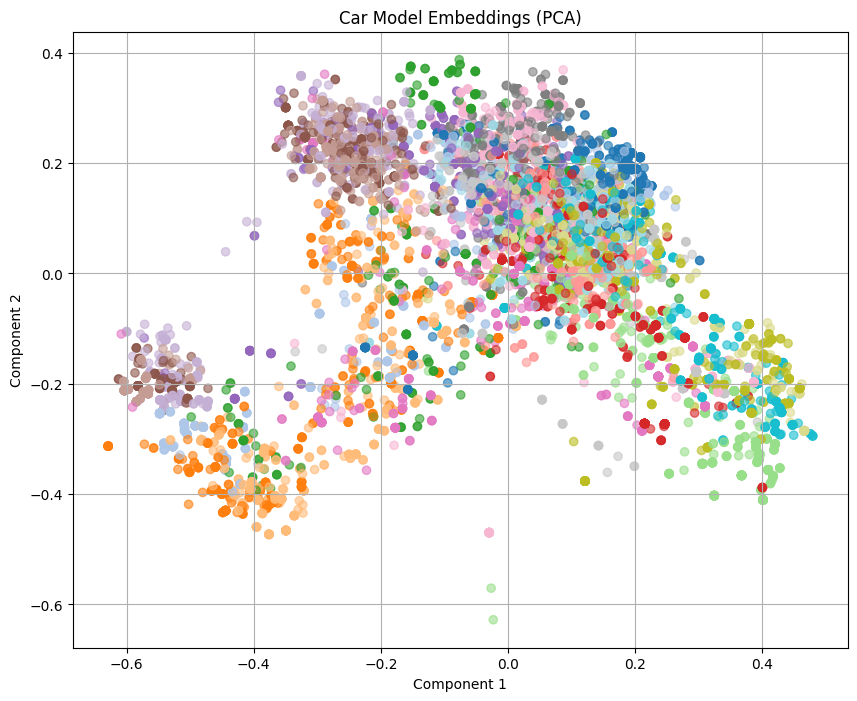

In [180]:
visualize_embeddings(final_df, method='pca')

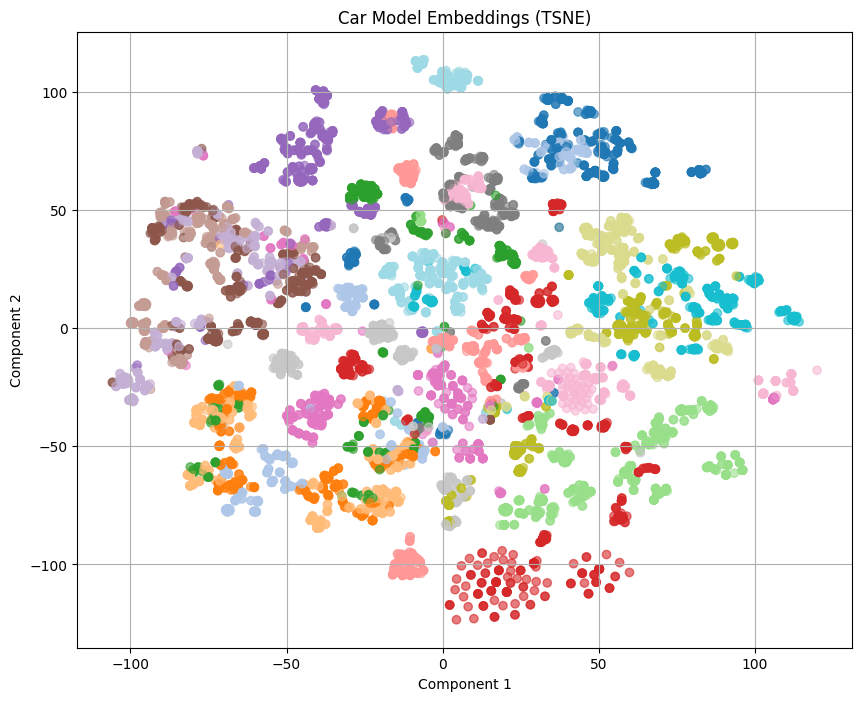

In [130]:
visualize_embeddings(final_df, method='tsne')


In [181]:
pd.set_option('display.max_columns', None)

final_df.drop(columns=['car_model'], inplace=True)

In [182]:
final_df.head()

,price,depreciation_per_year,coe_left,mileage,manufactured_year,road_tax_per_year,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,car_age,days_on_market,brand_alpina,brand_alpine,brand_aston martin,brand_audi,brand_austin,brand_b.m.w.,brand_bentley,brand_byd,brand_cadillac,brand_chery,brand_chevrolet,brand_chrysler,brand_citroen,brand_daihatsu,brand_datsun,brand_ferrari,brand_fiat,brand_ford,brand_honda,brand_hummer,brand_hyundai,brand_infiniti,brand_jaguar,brand_jeep,brand_kia,brand_lamborghini,brand_land rover,brand_lotus,brand_m.g.,brand_maserati,brand_maybach,brand_mazda,brand_mclaren,brand_mercedes benz,brand_mini,brand_mitsubishi,brand_mitsuoka,brand_morgan,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_proton,brand_renault,brand_rolls royce,brand_ruf,brand_saab,brand_seat,brand_skoda,brand_smart,brand_ssangyong,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo,color_black,color_blue,color_brown,color_gold,color_green,color_grey,color_maroon,color_multicolor,color_orange,color_pink,color_purple,color_red,color_silver,color_white,color_yellow,fuel_type_petrol,fuel_type_petrol-electric,transmission_manual,vehicle_type_luxury sedan,vehicle_type_mid-sized sedan,vehicle_type_mpv,vehicle_type_others,vehicle_type_sports car,vehicle_type_stationwagon,vehicle_type_suv,car_model_embedding
0,450000.0,52920.0,3099,69200,2003,4155.0,97931.0,123866.0,122414.0,161026.0,3246,261,1460,4,22,49,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,"[-0.07214942, 0.07592687, -0.04695741, 0.02077..."
1,888000.0,102380.0,3159,29000,2003,4953.0,110475.0,220263.0,138094.0,286342.0,3586,305,1290,2,22,24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,"[-0.048727825, 0.040641293, -0.13958333, 0.046..."
2,108888.0,13190.0,3010,135000,2003,1800.0,93804.0,30485.0,117255.0,39631.0,1988,114,1440,2,22,10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,"[-0.0076986337, 0.022889111, -0.015529863, -0...."
3,180800.0,20080.0,3277,46000,2004,10611.0,84860.0,249670.0,106075.0,274637.0,5998,412,2410,6,21,24,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,"[-0.105546676, 0.055305284, -0.052193783, 0.02..."
4,450000.0,48050.0,3414,64700,2004,10026.0,81938.0,259435.0,102423.0,285379.0,5748,380,1825,4,21,27

In [183]:
final_df.to_csv('processed_used_cars.csv', index=False)

Text(0.5, 1.0, 'Distribution of Car Prices')

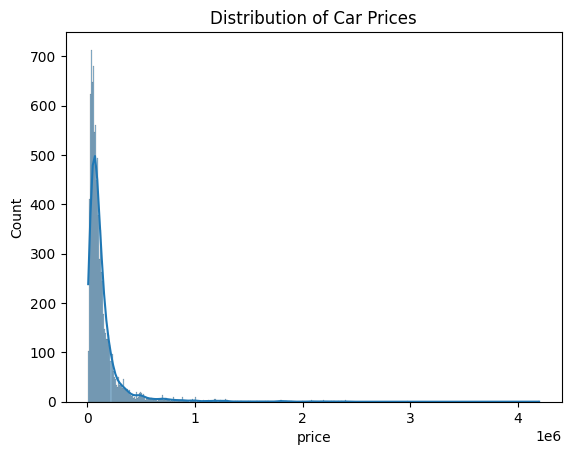

In [184]:
import seaborn as sns
sns.histplot(final_df['price'], kde=True)
plt.title('Distribution of Car Prices')

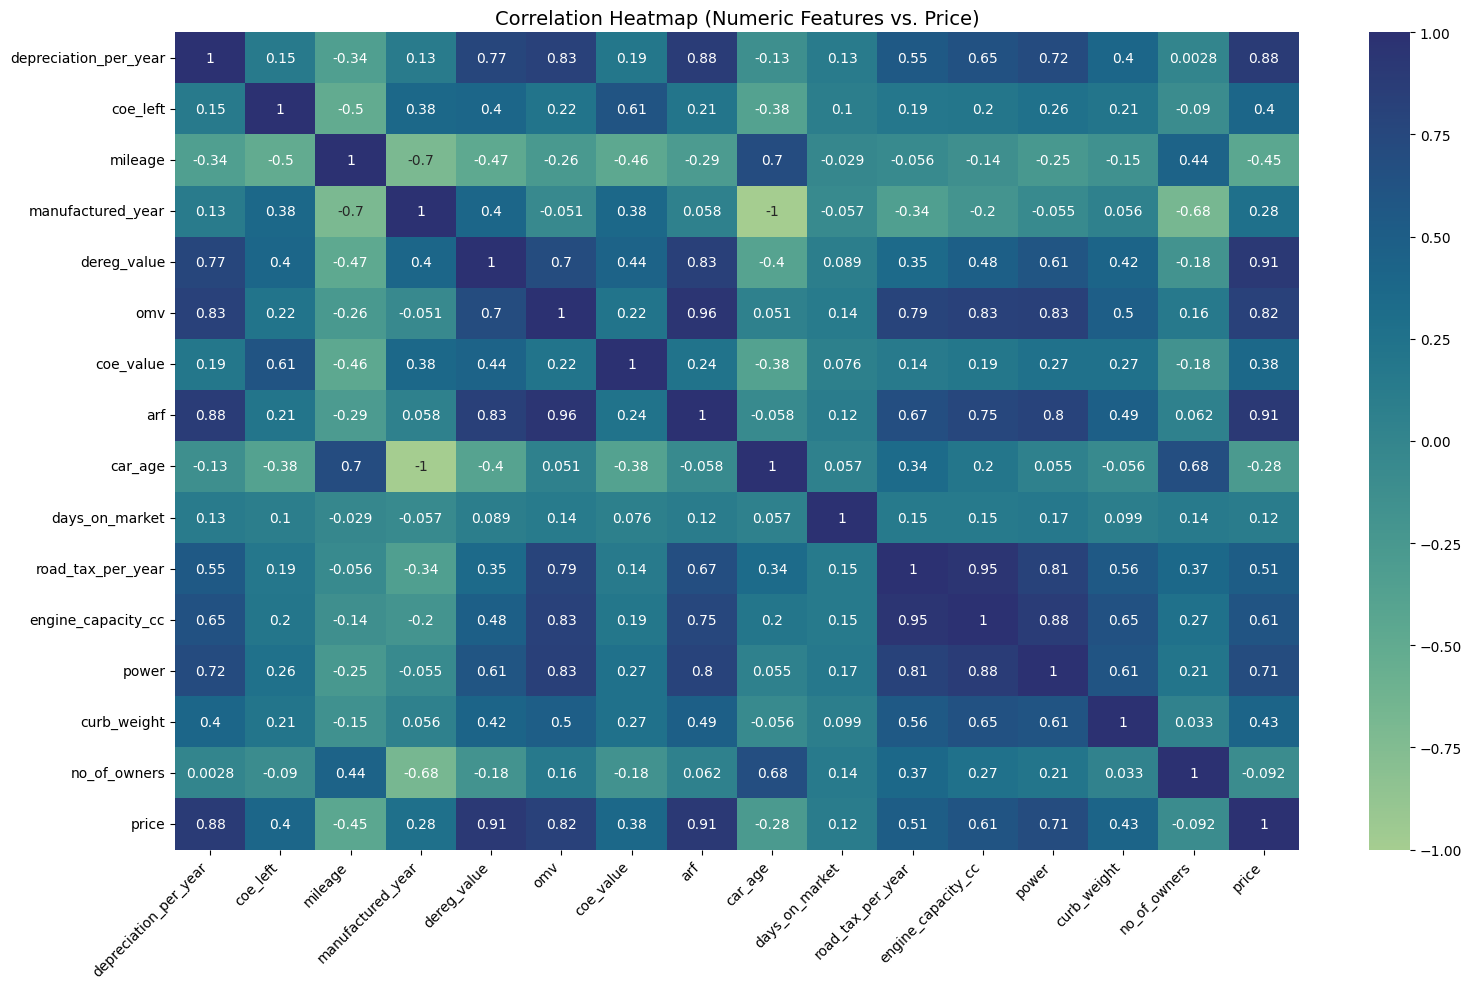

In [ ]:

plt.figure(figsize=(16, 10))
numeric_cols = ['depreciation_per_year', 'coe_left', 'mileage', 'manufactured_year', 'dereg_value', 'omv', 'coe_value', 'arf', 'car_age', 'days_on_market',
                'road_tax_per_year', 'engine_capacity_cc', 'power', 'curb_weight', 'no_of_owners']
sns.heatmap(final_df[numeric_cols + ['price']].corr(), annot=True, cmap="crest")


plt.title("Correlation Heatmap (Numeric Features vs. Price)", fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

In [165]:
final_df.head()
final_df.to_csv('processed_used_cars.csv', index=False)